# The whole process

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import cv2 as cv

from picamera.array import PiRGBArray
from picamera import PiCamera

import tensorflow as tf
from tensorflow import keras
import json

import subprocess
import tempfile

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Camera Initialization

In [2]:
camera = PiCamera()

In [3]:
rawCapture = PiRGBArray(camera)
camera.capture(rawCapture, format="rgb")
image = rawCapture.array

In [7]:
image.shape

(480, 800, 3)

In [8]:
image.dtype

dtype('uint8')

## Image capture and recognition

In [3]:
def get_image():
    rawCapture = PiRGBArray(camera)
    camera.capture(rawCapture, format="rgb")
    image = rawCapture.array
    plt.imshow(image)
    small_image = cv.resize(image[0:480, 160:640], dsize=(299,299))
    plt.imshow(small_image)
    small_image_f32 = np.float32(small_image)
    small_image_f32_r3 = np.expand_dims(small_image_f32, 0)
    scaled_image = small_image_f32_r3/255
    return scaled_image

In [4]:
iv3 = keras.applications.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

In [5]:
def predict_image(im):
    prediction = iv3.predict(im)
    return keras.applications.inception_v3.decode_predictions(prediction)

In [6]:
def capture_and_predict():
    im = get_image()
    prediction = predict_image(im)
    name = prediction[0][0][1]
    return name

'candle'

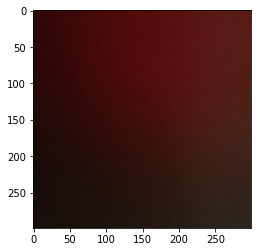

In [7]:
capture_and_predict()

## associations section

In [7]:
with open('./joern_api_responses.json', 'r') as f:
    thought_responses = json.load(f)

In [8]:
def category_to_thought(category):
    retval = None
    try:
        retval = thought_responses[category]
    except:
        retval = [category, "Beer"]
    return retval

## combining them

In [9]:
def capture_and_associate():
    category = capture_and_predict()
    stimulus, response = category_to_thought(category)
    return stimulus, response

('Dishwasher', 'Home_appliance')

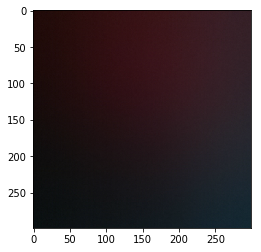

In [11]:
capture_and_associate()

## Talking

In [10]:
import tempfile

In [11]:
def say_something(text):
    number, fname = tempfile.mkstemp(suffix='.wav')
    command = 'pico2wave --wave={} -len-GB "{}" && aplay {} && rm {}'.format(
        fname,
        text,
        fname,
        fname
    )
    subprocess.Popen(['bash', '-c', command])

In [14]:
say_something('Hi, I like coffee.')

## Talking what is seen

In [15]:
def do_it():
    stimulus, response = capture_and_associate()
    string_to_speak = ". When I see {}, I think of {}.".format(stimulus, response)
    string_to_speak = string_to_speak.replace("_", " ")
    print(string_to_speak)
    say_something(string_to_speak)

. When I see Space Shuttle, I think of Japan.


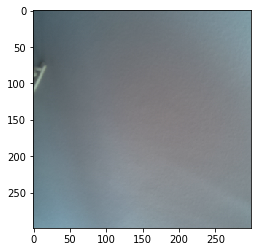

In [17]:
do_it()

In [19]:
%load_ext line_profiler

When I see Table tennis, I think of Sport.


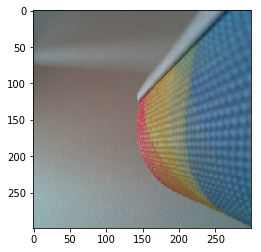

Timer unit: 1e-06 s

Total time: 3.59857 s
File: <ipython-input-29-8c6efe7ab0ec>
Function: capture_and_predict at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def capture_and_predict():
     2         1    1312348.0 1312348.0     36.5      im = get_image()
     3         1    2286207.0 2286207.0     63.5      prediction = predict_image(im)
     4         1          8.0      8.0      0.0      name = prediction[0][0][1]
     5         1          3.0      3.0      0.0      return name

In [69]:
%lprun -f capture_and_predict do_it()

When I see Table tennis, I think of Sport.


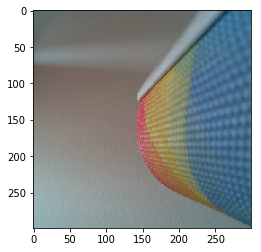

Timer unit: 1e-06 s

Total time: 1.30911 s
File: <ipython-input-4-f198d8bbc2ce>
Function: get_image at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_image():
     2         1        127.0    127.0      0.0      rawCapture = PiRGBArray(camera)
     3         1     477391.0 477391.0     36.5      camera.capture(rawCapture, format="rgb")
     4         1         10.0     10.0      0.0      image = rawCapture.array
     5         1     792027.0 792027.0     60.5      plt.imshow(image)
     6         1       8764.0   8764.0      0.7      small_image = cv.resize(image[0:480, 160:640], dsize=(299,299))
     7         1      22584.0  22584.0      1.7      plt.imshow(small_image)
     8         1       2729.0   2729.0      0.2      small_image_f32 = np.float32(small_image)
     9         1        154.0    154.0      0.0      small_image_f32_r3 = np.expand_dims(small_image_f32, 0)
    10         1       5311.0   53

In [70]:
%lprun -f get_image do_it()

When I see Table tennis, I think of Sport.


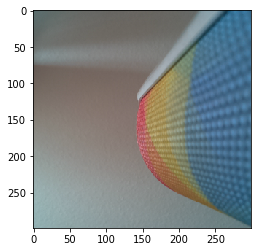

Timer unit: 1e-06 s

Total time: 2.22425 s
File: /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/_impl/keras/engine/training.py
Function: predict at line 1316

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1316                                             def predict(self, x, batch_size=None, verbose=0, steps=None):
  1317                                               """Generates output predictions for the input samples.
  1318                                           
  1319                                               Computation is done in batches.
  1320                                           
  1321                                               Arguments:
  1322                                                   x: The input data, as a Numpy array
  1323                                                       (or list of Numpy arrays if the model has multiple outputs).
  1324                                                   batch_size: Integer.

In [73]:
%lprun -f iv3.predict do_it()